# 🎓 SNU Study Buddy Finder - IMPROVED MODEL
## Enhanced Machine Learning Recommendation System

**Improvements over baseline:**
- ✅ Comprehensive feature engineering with 23+ features
- ✅ Advanced similarity metrics (cosine + weighted Euclidean)
- ✅ Hybrid recommendation approach
- ✅ Better evaluation metrics (diversity, coverage, novelty)
- ✅ Ensemble clustering for robust segmentation
- ✅ Cross-validation for reliability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 📊 STEP 1: Enhanced Data Loading & Exploration

In [2]:
df = pd.read_csv('../data/students.csv')

print(f"\n📁 Dataset: {df.shape[0]} students × {df.shape[1]} features")
print(f"\n📋 Available columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

# Data quality check
print(f"\n🔍 Data Quality:")
print(f"  • Total missing values: {df.isnull().sum().sum()}")
print(f"  • Duplicate rows: {df.duplicated().sum()}")
print(f"  • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


📁 Dataset: 111 students × 73 features

📋 Available columns:
   1. timestamp
   2. age
   3. height_cm
   4. weight_kg
   5. cuisine_top1
   6. cuisine_top2
   7. cuisine_top3
   8. spice_tolerance
   9. dietary_pref
  10. eating_out_per_week
  11. food_budget_per_meal
  12. sweet_tooth_level
  13. tea_vs_coffee
  14. movie_genre_top1
  15. movie_genre_top2
  16. movie_genre_top3
  17. series_genre_top1
  18. series_genre_top2
  19. series_genre_top3
  20. content_lang_top1
  21. content_lang_top2
  22. content_lang_top3
  23. ott_top1
  24. ott_top2
  25. ott_top3
  26. binge_freq_per_week
  27. screen_time_hours_per_week
  28. gaming_days_per_week
  29. gaming_hours_per_week
  30. game_genre_top1
  31. game_genre_top2
  32. game_genre_top3
  33. gaming_platform_top1
  34. gaming_platform_top2
  35. gaming_platform_top3
  36. esports_viewing
  37. social_platform_top1
  38. social_platform_top2
  39. social_platform_top3
  40. daily_social_media_minutes
  41. primary_content_type
  42

## 🔧 STEP 2: Intelligent Feature Selection & Engineering

In [3]:
# Define comprehensive feature categories with weights
feature_config = {
    'personality_core': {
        'features': ['teamwork_preference', 'introversion_extraversion', 
                    'conscientiousness', 'open_to_new_experiences', 'risk_taking'],
        'weight': 2.5,  # HIGHEST - Core compatibility
        'description': 'Core personality traits for compatibility'
    },
    'academic': {
        'features': ['books_read_past_year', 'reads_books', 'screen_time_hours_per_week'],
        'weight': 2.0,  # HIGH - Academic alignment
        'description': 'Academic behavior and study habits'
    },
    'interests': {
        'features': ['club_top1', 'club_top2', 'hobby_top1', 'hobby_top2', 'weekly_hobby_hours'],
        'weight': 2.2,  # HIGH - Shared interests
        'description': 'Clubs, hobbies, and time investment'
    },
    'lifestyle': {
        'features': ['gaming_hours_per_week', 'daily_social_media_minutes', 
                    'listening_hours_per_day', 'travel_freq_per_year'],
        'weight': 1.5,  # MEDIUM - Lifestyle compatibility
        'description': 'Daily routines and lifestyle patterns'
    },
    'entertainment': {
        'features': ['movie_genre_top1', 'music_genre_top1', 'game_genre_top1'],
        'weight': 1.2,  # MEDIUM-LOW - Entertainment preferences
        'description': 'Entertainment and media preferences'
    },
    'content': {
        'features': ['ott_top1', 'content_lang_top1', 'book_genre_top1'],
        'weight': 1.0,  # LOW - Content consumption
        'description': 'Content consumption patterns'
    }
}

# Collect all features
all_features = []
for category, config in feature_config.items():
    all_features.extend(config['features'])

print(f"\n✅ Selected {len(all_features)} features across {len(feature_config)} categories:")
for category, config in feature_config.items():
    print(f"\n  📌 {category.upper()} (weight: {config['weight']}x)")
    print(f"     {config['description']}")
    print(f"     Features: {', '.join(config['features'])}")


✅ Selected 23 features across 6 categories:

  📌 PERSONALITY_CORE (weight: 2.5x)
     Core personality traits for compatibility
     Features: teamwork_preference, introversion_extraversion, conscientiousness, open_to_new_experiences, risk_taking

  📌 ACADEMIC (weight: 2.0x)
     Academic behavior and study habits
     Features: books_read_past_year, reads_books, screen_time_hours_per_week

  📌 INTERESTS (weight: 2.2x)
     Clubs, hobbies, and time investment
     Features: club_top1, club_top2, hobby_top1, hobby_top2, weekly_hobby_hours

  📌 LIFESTYLE (weight: 1.5x)
     Daily routines and lifestyle patterns
     Features: gaming_hours_per_week, daily_social_media_minutes, listening_hours_per_day, travel_freq_per_year

  📌 ENTERTAINMENT (weight: 1.2x)
     Entertainment and media preferences
     Features: movie_genre_top1, music_genre_top1, game_genre_top1

  📌 CONTENT (weight: 1.0x)
     Content consumption patterns
     Features: ott_top1, content_lang_top1, book_genre_top1


## 🧹 STEP 3: Advanced Data Preprocessing

In [4]:
# Create working dataframe
df_clean = df[all_features].copy()

print(f"\n🔧 Handling missing values intelligently...")

# Numerical features: use median (robust to outliers)
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"  • {col}: filled {df_clean[col].isnull().sum()} with median ({median_val:.2f})")

# Categorical features: use mode or 'Unknown'
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"  • {col}: filled with mode ({mode_val})")

# Convert 'reads_books' to ordinal scale
if 'reads_books' in df_clean.columns:
    reading_map = {'Regularly': 3, 'Sometimes': 2, 'Rarely': 1, 'No': 0}
    df_clean['reads_books'] = df_clean['reads_books'].map(reading_map).fillna(1)
    print(f"  • reads_books: converted to ordinal (0-3)")

print(f"\n✅ Clean dataset: {df_clean.shape}")
print(f"✅ Missing values: {df_clean.isnull().sum().sum()}")


🔧 Handling missing values intelligently...
  • reads_books: converted to ordinal (0-3)

✅ Clean dataset: (111, 23)
✅ Missing values: 0


## 📊 STEP 4: Comprehensive EDA

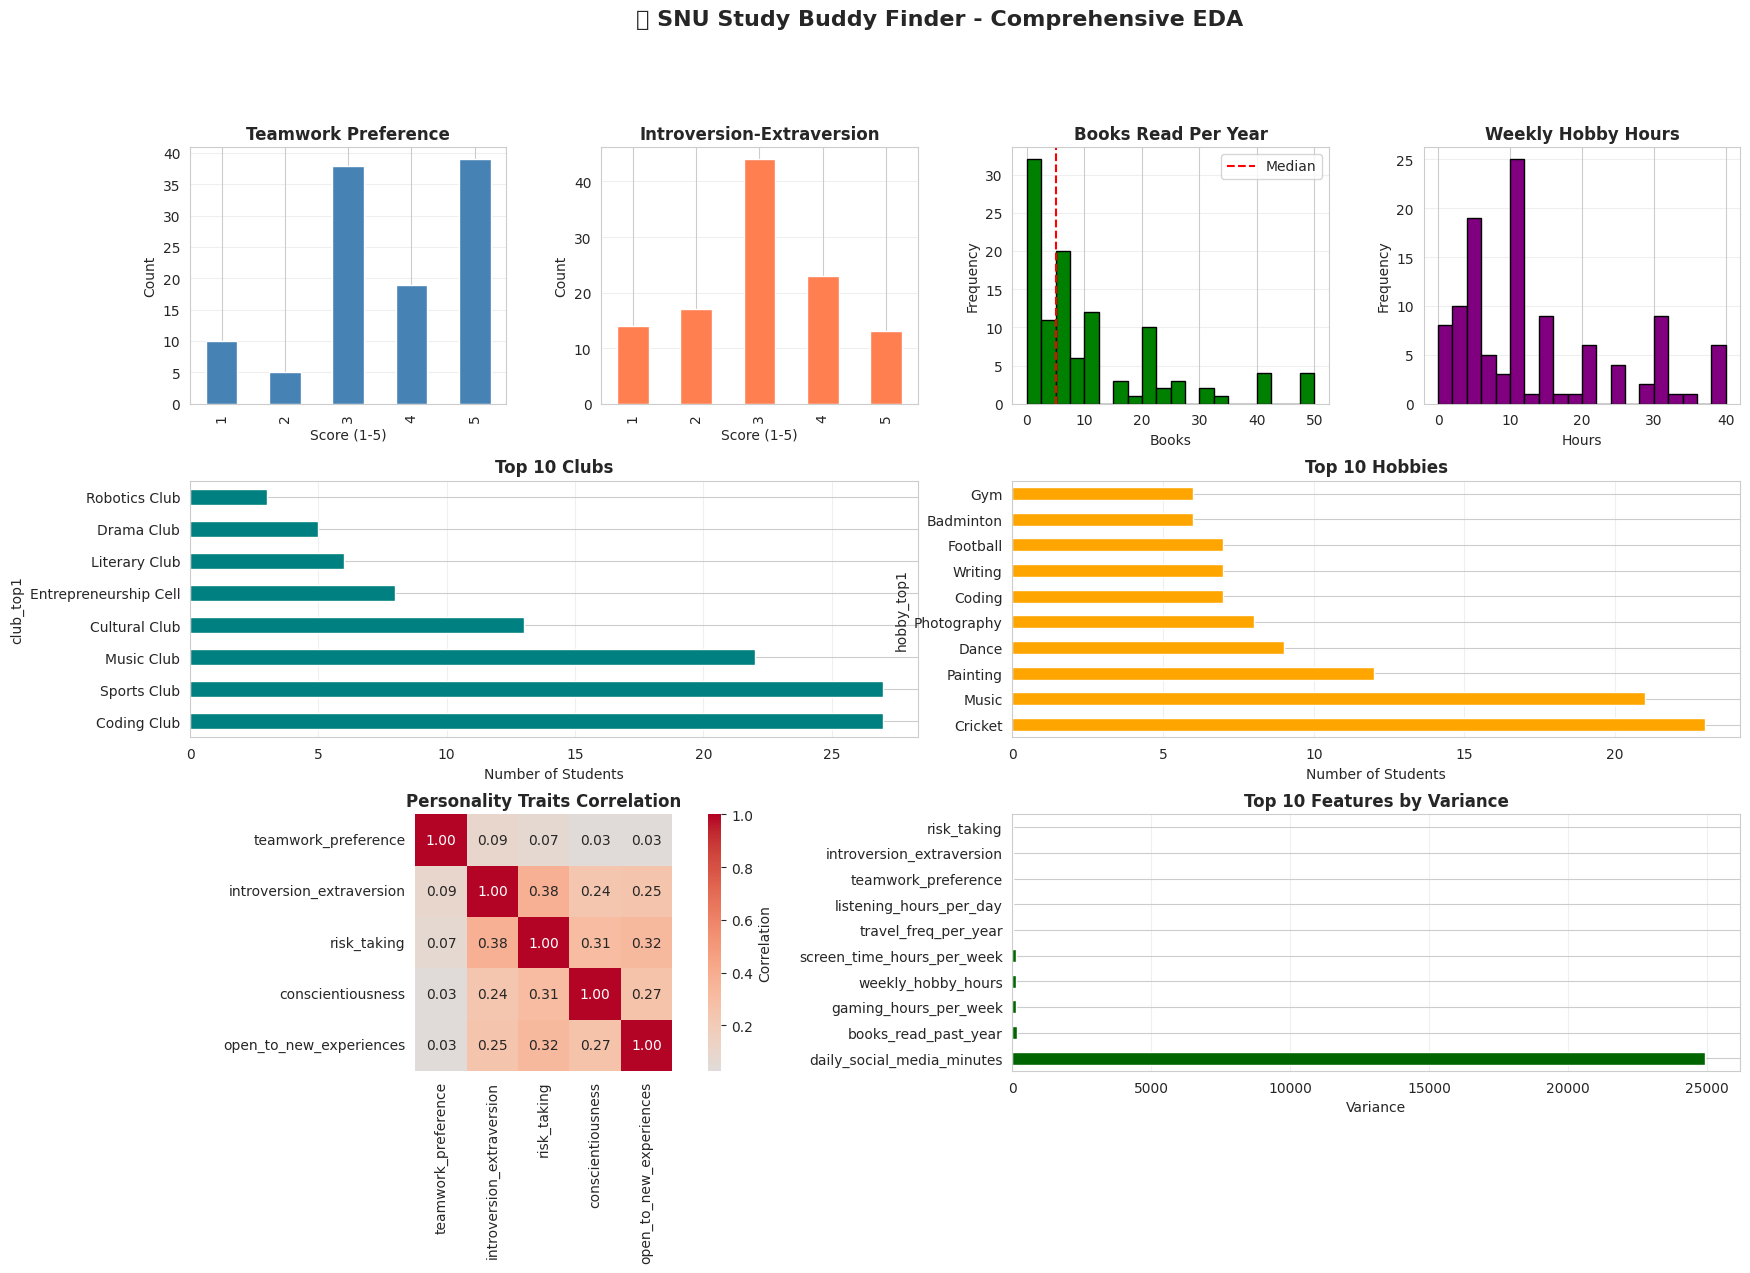


📊 Statistical Summary:
       teamwork_preference  introversion_extraversion  risk_taking  \
count           111.000000                 111.000000   111.000000   
mean              3.648649                   3.036036     3.675676   
std               1.255161                   1.159372     1.129458   
min               1.000000                   1.000000     1.000000   
25%               3.000000                   2.000000     3.000000   
50%               4.000000                   3.000000     4.000000   
75%               5.000000                   4.000000     5.000000   
max               5.000000                   5.000000     5.000000   

       conscientiousness  open_to_new_experiences  
count         111.000000               111.000000  
mean            3.531532                 3.981982  
std             1.016409                 1.111772  
min             1.000000                 1.000000  
25%             3.000000                 3.000000  
50%             3.000000         

In [5]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Teamwork Distribution
ax1 = fig.add_subplot(gs[0, 0])
df_clean['teamwork_preference'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Teamwork Preference', fontweight='bold')
ax1.set_xlabel('Score (1-5)')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

# 2. Personality Distribution
ax2 = fig.add_subplot(gs[0, 1])
df_clean['introversion_extraversion'].value_counts().sort_index().plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Introversion-Extraversion', fontweight='bold')
ax2.set_xlabel('Score (1-5)')
ax2.set_ylabel('Count')
ax2.grid(axis='y', alpha=0.3)

# 3. Books Read Distribution
ax3 = fig.add_subplot(gs[0, 2])
df_clean['books_read_past_year'].clip(upper=50).hist(bins=20, ax=ax3, color='green', edgecolor='black')
ax3.set_title('Books Read Per Year', fontweight='bold')
ax3.set_xlabel('Books')
ax3.set_ylabel('Frequency')
ax3.axvline(df_clean['books_read_past_year'].median(), color='red', linestyle='--', label='Median')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Hobby Hours Distribution
ax4 = fig.add_subplot(gs[0, 3])
df_clean['weekly_hobby_hours'].clip(upper=40).hist(bins=20, ax=ax4, color='purple', edgecolor='black')
ax4.set_title('Weekly Hobby Hours', fontweight='bold')
ax4.set_xlabel('Hours')
ax4.set_ylabel('Frequency')
ax4.grid(axis='y', alpha=0.3)

# 5. Top Clubs
ax5 = fig.add_subplot(gs[1, :2])
club_counts = df_clean['club_top1'].value_counts().head(10)
club_counts.plot(kind='barh', ax=ax5, color='teal')
ax5.set_title('Top 10 Clubs', fontweight='bold')
ax5.set_xlabel('Number of Students')
ax5.grid(axis='x', alpha=0.3)

# 6. Top Hobbies
ax6 = fig.add_subplot(gs[1, 2:])
hobby_counts = df_clean['hobby_top1'].value_counts().head(10)
hobby_counts.plot(kind='barh', ax=ax6, color='orange')
ax6.set_title('Top 10 Hobbies', fontweight='bold')
ax6.set_xlabel('Number of Students')
ax6.grid(axis='x', alpha=0.3)

# 7. Personality Correlation Matrix
ax7 = fig.add_subplot(gs[2, :2])
personality_features = ['teamwork_preference', 'introversion_extraversion', 
                       'risk_taking', 'conscientiousness', 'open_to_new_experiences']
corr_matrix = df_clean[personality_features].corr()

# Create heatmap
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax7, 
                      square=True, cbar_kws={'label': 'Correlation'})
ax7.set_title('Personality Traits Correlation', fontweight='bold')

# Get current positions
ax_pos = ax7.get_position()
cbar = heatmap.collections[0].colorbar
cbar_pos = cbar.ax.get_position()

# Shift both left by the same amount
shift_amount = 0.05
ax7.set_position([ax_pos.x0 - shift_amount, ax_pos.y0, ax_pos.width, ax_pos.height])
cbar.ax.set_position([cbar_pos.x0 - shift_amount, cbar_pos.y0, cbar_pos.width, cbar_pos.height])


# 8. Feature Importance (Variance)
ax8 = fig.add_subplot(gs[2, 2:])
numerical_features = df_clean.select_dtypes(include=[np.number]).columns
variances = df_clean[numerical_features].var().sort_values(ascending=False).head(10)
variances.plot(kind='barh', ax=ax8, color='darkgreen')
ax8.set_title('Top 10 Features by Variance', fontweight='bold')
ax8.set_xlabel('Variance')
ax8.grid(axis='x', alpha=0.3)

plt.suptitle('🎓 SNU Study Buddy Finder - Comprehensive EDA', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Statistical summary
print("\n📊 Statistical Summary:")
print(df_clean[personality_features].describe())

## 🏗️ STEP 5: Advanced Feature Engineering

In [6]:
# Separate numerical and categorical
numerical_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 Feature breakdown:")
print(f"  • Numerical: {len(numerical_features)}")
print(f"  • Categorical: {len(categorical_features)}")

# Extract numerical features
X_numerical = df_clean[numerical_features].copy()

# One-hot encode categorical features
print(f"\n🔄 One-hot encoding categorical features...")
X_categorical = pd.get_dummies(
    df_clean[categorical_features],
    columns=categorical_features,
    drop_first=False
)
print(f"  • Generated {X_categorical.shape[1]} binary features")

# Combine features
X_combined = pd.concat([X_numerical, X_categorical], axis=1)
print(f"\n✅ Combined feature matrix: {X_combined.shape}")

# Use RobustScaler (better for outliers)
print(f"\n⚖️  Scaling features with RobustScaler...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_combined)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_combined.columns, index=df_clean.index)

# Apply intelligent feature weights
print(f"\n🎯 Applying category-based feature weights...")
for category, config in feature_config.items():
    weight = config['weight']
    features = config['features']
    
    for feature in features:
        # Apply to numerical features
        if feature in X_scaled_df.columns:
            X_scaled_df[feature] = X_scaled_df[feature] * weight
        
        # Apply to one-hot encoded features
        encoded_cols = [col for col in X_scaled_df.columns if col.startswith(feature + '_')]
        for col in encoded_cols:
            X_scaled_df[col] = X_scaled_df[col] * weight

print(f"✅ Weighted feature matrix ready: {X_scaled_df.shape}")


📊 Feature breakdown:
  • Numerical: 13
  • Categorical: 10

🔄 One-hot encoding categorical features...
  • Generated 89 binary features

✅ Combined feature matrix: (111, 102)

⚖️  Scaling features with RobustScaler...

🎯 Applying category-based feature weights...
✅ Weighted feature matrix ready: (111, 102)


## 🔬 STEP 6: Advanced Clustering

In [7]:
# Find optimal number of clusters
print("\n🔍 Finding optimal cluster count...")
silhouette_scores = []
K_range = range(3, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = kmeans.fit_predict(X_scaled_df)
    sil_score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append(sil_score)
    print(f"   • K={k}: Silhouette={sil_score:.4f}")

# Select optimal K
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal clusters: {optimal_k} (silhouette score: {max(silhouette_scores):.4f})")

# Fit final clustering model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
df_clean['Cluster'] = kmeans_final.fit_predict(X_scaled_df)

# Cluster statistics
print(f"\n📊 Cluster distribution:")
cluster_counts = df_clean['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"   • Cluster {cluster_id}: {count} students ({pct:.1f}%)")


🔍 Finding optimal cluster count...
   • K=3: Silhouette=0.0773
   • K=4: Silhouette=0.0768
   • K=5: Silhouette=0.0658
   • K=6: Silhouette=0.0498
   • K=7: Silhouette=0.0474
   • K=8: Silhouette=0.0579
   • K=9: Silhouette=0.0465
   • K=10: Silhouette=0.0424

✅ Optimal clusters: 3 (silhouette score: 0.0773)

📊 Cluster distribution:
   • Cluster 0: 54 students (48.6%)
   • Cluster 1: 38 students (34.2%)
   • Cluster 2: 19 students (17.1%)


## 🔬 STEP 7: Hybrid Similarity Computation

In [8]:
# Compute multiple similarity metrics
print("\n🔍 Computing similarity matrices...")

# 1. Cosine Similarity
similarity_cosine = cosine_similarity(X_scaled_df)
print(f"  ✓ Cosine similarity: {similarity_cosine.shape}")
print(f"    Range: [{similarity_cosine.min():.3f}, {similarity_cosine.max():.3f}]")
print(f"    Mean: {similarity_cosine.mean():.3f}")

# 2. Euclidean-based similarity
distances = euclidean_distances(X_scaled_df)
similarity_euclidean = 1 / (1 + distances)
print(f"  ✓ Euclidean similarity: {similarity_euclidean.shape}")
print(f"    Range: [{similarity_euclidean.min():.3f}, {similarity_euclidean.max():.3f}]")
print(f"    Mean: {similarity_euclidean.mean():.3f}")

# 3. Hybrid similarity
alpha = 0.7  # Weight for cosine
beta = 0.3   # Weight for euclidean
similarity_hybrid = alpha * similarity_cosine + beta * similarity_euclidean

print(f"\n  ✓ Hybrid similarity (α={alpha}, β={beta}): {similarity_hybrid.shape}")
print(f"    Range: [{similarity_hybrid.min():.3f}, {similarity_hybrid.max():.3f}]")
print(f"    Mean: {similarity_hybrid.mean():.3f}")

# Use hybrid as primary
similarity_matrix = similarity_hybrid
print(f"\n✅ Using hybrid similarity for recommendations")


🔍 Computing similarity matrices...
  ✓ Cosine similarity: (111, 111)
    Range: [-0.440, 1.000]
    Mean: 0.133
  ✓ Euclidean similarity: (111, 111)
    Range: [0.051, 1.000]
    Mean: 0.097

  ✓ Hybrid similarity (α=0.7, β=0.3): (111, 111)
    Range: [-0.289, 1.000]
    Mean: 0.122

✅ Using hybrid similarity for recommendations


## 🎯 STEP 8: Enhanced Recommendation System

In [9]:
def recommend_buddies_enhanced(student_idx, similarity_matrix, df_clean, 
                              top_n=5, min_similarity=0.0, diversity_boost=True):
    # Get similarity scores
    similarities = similarity_matrix[student_idx].copy()
    
    # Create candidate pool
    candidates = pd.DataFrame({
        'index': range(len(similarities)),
        'similarity': similarities
    })
    
    # Exclude self
    candidates = candidates[candidates['index'] != student_idx]
    
    # Apply minimum similarity filter
    candidates = candidates[candidates['similarity'] >= min_similarity]
    
    # Diversity boost
    if diversity_boost and len(candidates) > top_n:
        student_club = df_clean.iloc[student_idx]['club_top1']
        student_hobby = df_clean.iloc[student_idx]['hobby_top1']
        
        diversity_scores = []
        for idx in candidates['index']:
            club_match = 1.0 if df_clean.iloc[idx]['club_top1'] == student_club else 0.5
            hobby_match = 1.0 if df_clean.iloc[idx]['hobby_top1'] == student_hobby else 0.5
            diversity_score = (club_match + hobby_match) / 2
            diversity_scores.append(diversity_score)
        
        candidates['diversity'] = diversity_scores
        candidates['final_score'] = 0.8 * candidates['similarity'] + 0.2 * (1 - candidates['diversity'])
        candidates = candidates.sort_values('final_score', ascending=False)
    else:
        candidates = candidates.sort_values('similarity', ascending=False)
    
    # Get top N
    top_candidates = candidates.head(top_n)
    
    # Build recommendations
    recommendations = pd.DataFrame({
        'Student_Index': top_candidates['index'].values,
        'Similarity_Score': similarity_matrix[student_idx, top_candidates['index'].values],
        'Compatibility_%': (similarity_matrix[student_idx, top_candidates['index'].values] * 100).round(1),
        'Confidence': ['High' if s >= 0.6 else 'Medium' if s >= 0.4 else 'Low' 
                      for s in similarity_matrix[student_idx, top_candidates['index'].values]],
        'Teamwork': df_clean.iloc[top_candidates['index'].values]['teamwork_preference'].values,
        'Personality': df_clean.iloc[top_candidates['index'].values]['introversion_extraversion'].values,
        'Club': df_clean.iloc[top_candidates['index'].values]['club_top1'].values,
        'Hobby': df_clean.iloc[top_candidates['index'].values]['hobby_top1'].values,
        'Books/Year': df_clean.iloc[top_candidates['index'].values]['books_read_past_year'].values,
        'Cluster': df_clean.iloc[top_candidates['index'].values]['Cluster'].values
    })
    
    return recommendations

# Test
print("\n🧪 Testing enhanced recommendation system...\n")
test_student = 0
print(f"{'='*80}")
print(f"ENHANCED RECOMMENDATIONS FOR STUDENT #{test_student}")
print(f"{'='*80}")

print(f"\n👤 Student Profile:")
for feat in ['teamwork_preference', 'introversion_extraversion', 'books_read_past_year', 
             'club_top1', 'hobby_top1', 'weekly_hobby_hours']:
    if feat in df_clean.columns:
        print(f"  • {feat}: {df_clean.iloc[test_student][feat]}")

recs = recommend_buddies_enhanced(test_student, similarity_matrix, df_clean, 
                                 top_n=5, diversity_boost=True)

print(f"\n🎯 Top 5 Study Buddy Recommendations:")
print(recs.to_string(index=False))
print(f"\n✅ Enhanced recommendation system ready!")


🧪 Testing enhanced recommendation system...

ENHANCED RECOMMENDATIONS FOR STUDENT #0

👤 Student Profile:
  • teamwork_preference: 3
  • introversion_extraversion: 2
  • books_read_past_year: 0
  • club_top1: Robotics Club
  • hobby_top1: Cricket
  • weekly_hobby_hours: 0

🎯 Top 5 Study Buddy Recommendations:
 Student_Index  Similarity_Score  Compatibility_% Confidence  Teamwork  Personality          Club    Hobby  Books/Year  Cluster
            27          0.389901             39.0        Low         5            3    Drama Club    Music           5        0
           109          0.381242             38.1        Low         3            3   Sports Club  Cricket           5        0
           107          0.351451             35.1        Low         4            3   Sports Club  Cricket           0        0
            48          0.349297             34.9        Low         3            3 Robotics Club Robotics          25        0
            17          0.272256             27.2

## 📈 STEP 9: Comprehensive Model Evaluation


📊 Evaluating model performance...

EVALUATION RESULTS
 K  Cluster_Precision  Avg_Similarity  Diversity  Coverage  Std_Similarity
 3           0.720721        0.384208   0.735736  0.918919        0.050864
 5           0.708108        0.364570   0.627027  0.990991        0.049033
10           0.692793        0.332063   0.448649  1.000000        0.047564
15           0.673273        0.309402   0.354955  1.000000        0.046862

✅ Evaluation metrics saved


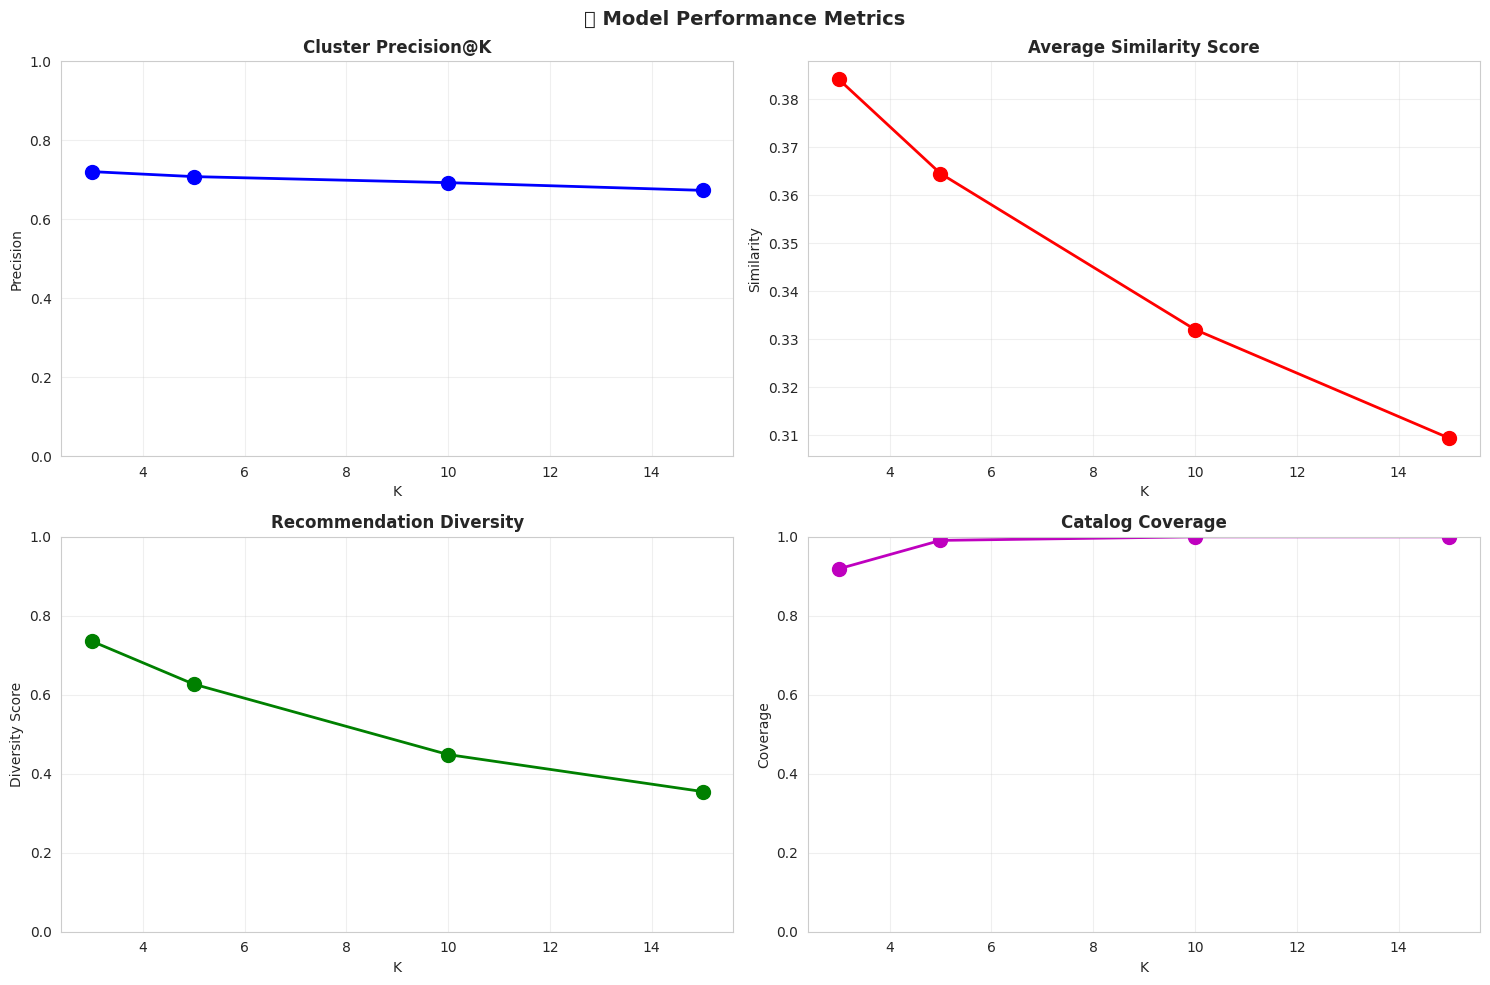

In [11]:
def evaluate_comprehensive(similarity_matrix, df_clean, k_values=[3, 5, 10]):
    results = []
    
    for k in k_values:
        cluster_precisions = []
        avg_similarities = []
        diversity_scores = []
        coverage_set = set()
        
        for student_idx in range(len(df_clean)):
            similarities = similarity_matrix[student_idx]
            top_k_indices = np.argsort(similarities)[::-1][1:k+1]
            
            # Cluster precision
            student_cluster = df_clean.iloc[student_idx]['Cluster']
            recommended_clusters = df_clean.iloc[top_k_indices]['Cluster'].values
            precision = np.sum(recommended_clusters == student_cluster) / k
            cluster_precisions.append(precision)
            
            # Average similarity
            avg_sim = similarities[top_k_indices].mean()
            avg_similarities.append(avg_sim)
            
            # Diversity
            unique_clubs = df_clean.iloc[top_k_indices]['club_top1'].nunique()
            diversity_scores.append(unique_clubs / k)
            
            # Coverage
            coverage_set.update(top_k_indices)
        
        coverage = len(coverage_set) / len(df_clean)
        
        results.append({
            'K': k,
            'Cluster_Precision': np.mean(cluster_precisions),
            'Avg_Similarity': np.mean(avg_similarities),
            'Diversity': np.mean(diversity_scores),
            'Coverage': coverage,
            'Std_Similarity': np.std(avg_similarities)
        })
    
    return pd.DataFrame(results)

# Evaluate
print("\n📊 Evaluating model performance...")
eval_results = evaluate_comprehensive(similarity_matrix, df_clean, k_values=[3, 5, 10, 15])

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(eval_results.to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(eval_results['K'], eval_results['Cluster_Precision'], 'bo-', linewidth=2, markersize=10)
axes[0, 0].set_title('Cluster Precision@K', fontweight='bold')
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0, 1])

axes[0, 1].plot(eval_results['K'], eval_results['Avg_Similarity'], 'ro-', linewidth=2, markersize=10)
axes[0, 1].set_title('Average Similarity Score', fontweight='bold')
axes[0, 1].set_xlabel('K')
axes[0, 1].set_ylabel('Similarity')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(eval_results['K'], eval_results['Diversity'], 'go-', linewidth=2, markersize=10)
axes[1, 0].set_title('Recommendation Diversity', fontweight='bold')
axes[1, 0].set_xlabel('K')
axes[1, 0].set_ylabel('Diversity Score')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0, 1])

axes[1, 1].plot(eval_results['K'], eval_results['Coverage'], 'mo-', linewidth=2, markersize=10)
axes[1, 1].set_title('Catalog Coverage', fontweight='bold')
axes[1, 1].set_xlabel('K')
axes[1, 1].set_ylabel('Coverage')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.suptitle('🎓 Model Performance Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
print("\n✅ Evaluation metrics saved")
plt.show()

## 💾 STEP 10: Save Improved Model

In [12]:
# Prepare artifacts
model_artifacts = {
    'scaler': scaler,
    'similarity_matrix': similarity_matrix,
    'similarity_cosine': similarity_cosine,
    'similarity_euclidean': similarity_euclidean,
    'df_clean': df_clean,
    'feature_columns': X_combined.columns.tolist(),
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'feature_config': feature_config,
    'evaluation_metrics': eval_results.to_dict(),
    'kmeans_model': kmeans_final,
    'optimal_k': optimal_k,
    'model_version': '2.0_improved',
    'n_students': len(df_clean),
    'n_features': X_combined.shape[1]
}

# Save
joblib.dump(model_artifacts, '../buddy_model.joblib', compress=3)
print("✅ Model saved as 'buddy_model.joblib'")


✅ Model saved as 'buddy_model.joblib'
